# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science 


## XGBoost Analysis

**Harvard University**<br>
**Spring 2020**<br>
Jack Luby, Hakeem Angulu, and Louie Ayre <br>

---



### XGBoost

XGBoost (eXtreme Gradient Boosting) is a python library for parallel tree gradient boosting. The library has been lauded for its efficiency and performance.

In [1]:
## Set formatting to CS109 standard
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
# The classics
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

In [3]:
# For this notebook
import xgboost as xgb
from xgboost import XGBRegressor

import shap
shap.initjs()

## Load In

In [4]:
main_df = pd.read_csv('data/main.csv')

In [5]:
responses = ['infection_rate', 'death_rate', 'death_rate_amongst_infected']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(main_df.drop(responses + ['fips'], axis=1),
                                                    main_df[responses], test_size=0.2,
                                                    random_state=109)

## Predicting Covid Cases

#### XGBoost and SHAP

We'd like to use our available variables to predict the number of cases in a given county. Additionally, we'd like to know the extent to which these cases are predicted by race and income factors. Here, we use XGBoost to establish a model of cases and SHAP (SHapley Additive exPlanations) to explain our predictions.

In [7]:
case_train = y_train['infection_rate']
case_test = y_test['infection_rate']

In [8]:
# Cross validate for n_estimators and learning rate.
# MSE metric is not included in xgb library so we won't
# be able to use early_stopping_rounds. We'll have to
# grid search over n_estimators and max_depth ourselves.
# As a result, we won't have access to the early_stopping
# parameter but XGBoost does a good job with more trees
# so we'll just waste a bit of time and see where we
# coverge.

In [9]:
def gridsearch_mse(y_train):
    gridsearch_params = [
        (max_depth, n_estimators)
        for max_depth in range(2,8)
        for n_estimators in range(20,200,20)
    ]

    scores = []

    for max_depth, n_estimators in gridsearch_params:

        # Set XGB and fit
        xgb_model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=0.05)
        score = cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean()
        scores.append([max_depth, n_estimators, -score])

    scores = pd.DataFrame(scores, columns = ['Depth', 'N_Trees', 'MSE'])
    
    return scores

#### Gridsearch

Using a cross-validated gridsearch through a reasonable range of depth and n_trees parameters, we optimize our XGBoost hyperparameters. As shown below, we are able to minimize MSE using a maximum tree depth of 5. 

In [10]:
case_scores = gridsearch_mse(case_train)

case_scores.groupby(['Depth'])['MSE'].min()

Depth
2    0.000024
3    0.000023
4    0.000023
5    0.000023
6    0.000023
7    0.000024
Name: MSE, dtype: float64

#### n_estimators

We also consider the n_estimators parameter, representing the number of trees used in our model. XGBoost is able to handle high numbers of trees well, such that we tend to avoid overfitting. We see a convergence of MSE values at around 100 trees.

In [11]:
def plot_best_depth(scores):
    best_depth = scores[scores['MSE'] == scores['MSE'].min()]['Depth'].values[0]
    ax = sns.lineplot(scores[case_scores['Depth'] == best_depth]['N_Trees'],
                 scores[case_scores['Depth'] == best_depth]['MSE'])
    ax.set(xlabel='Number of Trees', ylabel='MSE', title = f'Model Performance vs. Tree Depth at Optimal Depth ({best_depth})')
    plt.show()

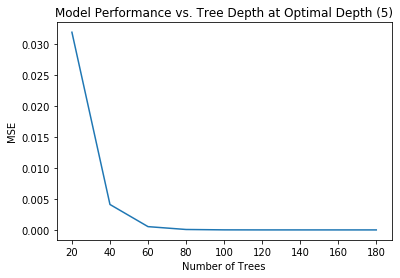

In [12]:
plot_best_depth(case_scores)

#### Fitting the model

Using these optimized parameters, we fit our model to the training set and predict using the test set. The MSE of this best model is 9.1e-06.

In [13]:
# Fit our model using selected parameters
xgb_model = XGBRegressor(n_estimators=150, max_depth=5, learning_rate=0.05)
xgb_model.fit(X_train, case_train)
case_pred = xgb_model.predict(X_test)
print(f'Best Model Test MSE: {round(mean_squared_error(case_test, case_pred),7)}')

Best Model Test MSE: 9.1e-06


#### Feature Dependence

Next, we'd like to understand the features of our data that are driving predictions. Do counties with large populations of color tend to face higher incidence of Covid-19? Have early adopters seen material benefits by way of  reduced Covid-19 spread? To explore these questions, we make use of the SHAP package.

In [14]:
# Explain model predictions using shap library:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### Analysis

The figure below demonstrates the associations of variables with the incidence of Covid-19 cases in a given county. Horizontal location is representative of a variable's value and its color is representative of its predictive power on Covid-19 incidence. That is to say, red values to the right indicate a positive correlation between a variable and Covid-19 incidence. Variables are arranged in descending order of importance.


#### Education and Income

Somewhat counterintuitively, education and income appear to be positively correlated with Covid-19 case incidence. This effect may be due to regional factors (i.e. North Eastern counties tend to be more educated and earn higher wages than Southern counties). It may also be that highly educated areas are more likely to test.

#### Race

Racial factors are of high predictive importance. High proportions of black, asian, and hispanic residents is positively correlated with Covid-19 case incidence, while a county's proportion of white residents is negatively correlated with virus incidence. Our results align with reports regarding racial disparities in Covid-19 virus incidence. The importance of these factors relative to other factors, especially population density, is incredibly concerning. In light of these trends, measures may be needed to address the apparent racial inequities of this illness.

#### Days Since Closing Non-Essential Businesses

We find that days since closing non-essential businesses appears to be postively correlated with the number of days since a county closed non-essential businesses. Though this seems counterintuitive, it is sensible that those counties facing the greatest threat of Covid-19 would have shut down earlier. Further, those counties who saw high incidence of the virus early have had the most time to see growth in its spread and accumulate cases.

#### Population Density

Population density is the most important predictor of Covid-19 case incidence. This is sensible. Those counties with the most people in the least space are likely to face high virus reproduction rates.

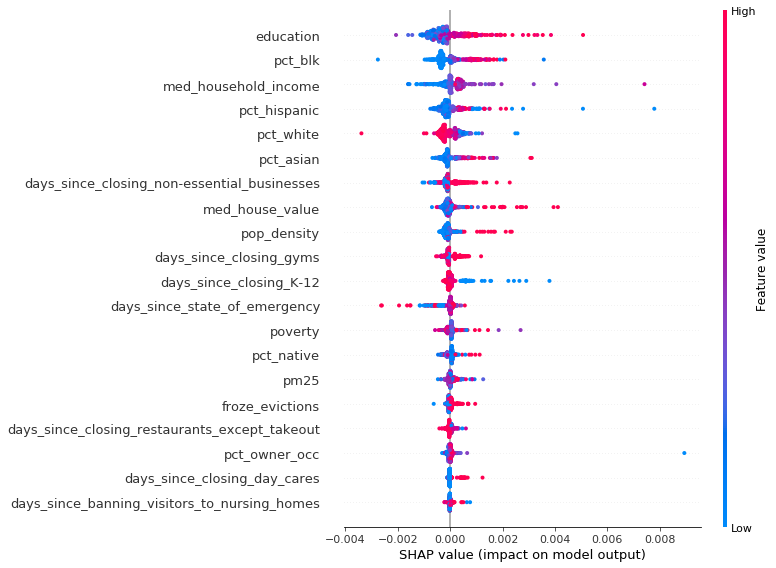

In [15]:
shap.summary_plot(shap_values, X_test)

## Predicting Deaths

We follow the same methodology in analyzing mortality rates from Covid-19. Again, a tree depth of 3 provides the best fit we see convergence ~80 trees.

In [16]:
death_train = y_train['death_rate']
death_test = y_test['death_rate']

In [17]:
death_scores = gridsearch_mse(death_train)

death_scores.groupby(['Depth'])['MSE'].min()

Depth
2    8.287868e-08
3    8.075994e-08
4    8.102628e-08
5    8.106676e-08
6    8.105556e-08
7    8.105556e-08
Name: MSE, dtype: float64

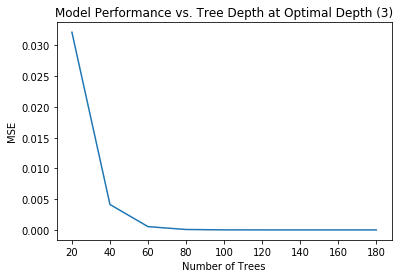

In [18]:
plot_best_depth(death_scores)

#### Fitting the model

Using the above optimized parameters, we fit our model to the training set and predict using the test set. The MSE of this best model is 1e-07.

In [19]:
# Fit our model using selected parameters
xgb_model = XGBRegressor(n_estimators=150, max_depth=3, learning_rate=0.05)
xgb_model.fit(X_train, death_train)
death_pred = xgb_model.predict(X_test)
print(f'Best Model Test MSE: {round(mean_squared_error(death_test, death_pred),7)}')

Best Model Test MSE: 1e-07


#### Fitting the model

Using these optimized parameters, we fit our model to the training set and predict using the test set. The MSE of this best model is 1.09e-05.

In [20]:
# Explain model predictions using shap library:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### Analysis

The figure below demonstrates the associations of variables with the incidence of Covid-19 deaths in a given county. Horizontal location is representative of a variable's value and its color is representative of its predictive power on Covid-19 mortality. That is to say, red values to the right indicate a positive correlation between a variable and Covid-19 incidence. Variables are arranged in descending order of importance.

#### Population Density

Population density is the most important predictor of Covid-19 mortality. Those counties with the most people in the least space are likely to face high virus reproduction rates as well as acutely strained medical infrastructure.

#### Race

Again, the association between racial factors and Covid mortality is striking. Counties with large black populations tend to see increased mortality due to the virus. Pct_black is the 2nd most important feature behind population density, while pct_white is the fourth. Black communities appear to be at severely increased risk of mortality from this virus relative to white communities.

#### Days Since Closing Non-Essential Businesses

The same associations noted above regarding days since shutdown are seen in the case of Covid mortality. As above, early virus incidence is likely to be associated with ongoing risk of spread and death.

#### Poverty

County poverty is positively correlated with Covid-19 mortality. This fact represent, concerningly, that the poorest counties of the US are at highest risk of mortality from this virus due to their lack of access to medical resources. Additional measures may be needed to address these concerning race and income effects. 

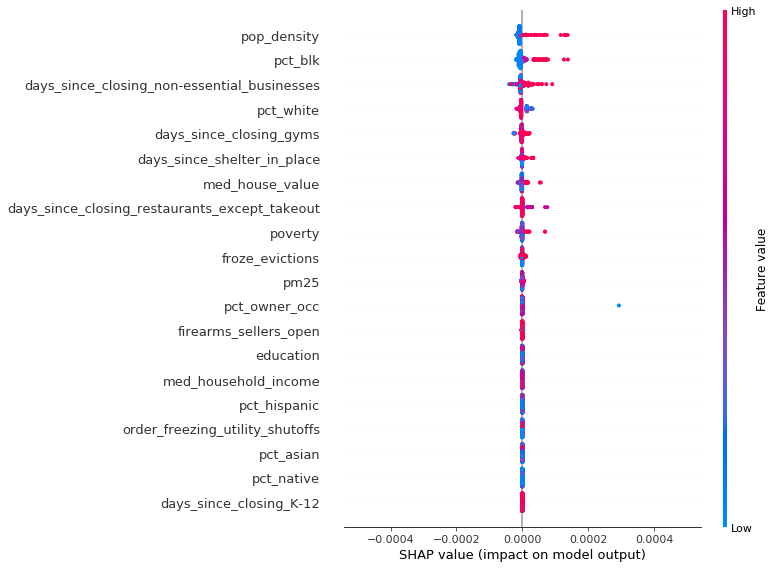

In [21]:
shap.summary_plot(shap_values, X_test)

## Predicting Death Rates

Finally, we'd like to understand the determinants of death rates from Covid-19. What factors determine which patients will die from their infection? While these results are likely to be skewed by the fact that some counties test at higher rates than others, there could nonetheless be informative trends in the data (especially regarding income and racial effects).

In [22]:
rate_train = y_train['death_rate_amongst_infected']
rate_test = y_test['death_rate_amongst_infected']

In [23]:
rate_scores = gridsearch_mse(rate_train)

rate_scores.groupby(['Depth'])['MSE'].min()

Depth
2    0.004523
3    0.004534
4    0.004644
5    0.004680
6    0.004701
7    0.004689
Name: MSE, dtype: float64

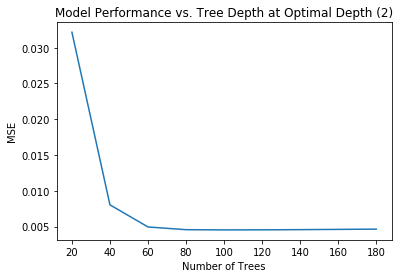

In [24]:
plot_best_depth(rate_scores)

#### Fitting the model

Using the above optimized parameters, we fit our model to the training set and predict using the test set. The MSE of this best model is .0037297.

In [28]:
# Fit our model using selected parameters
xgb_model = XGBRegressor(n_estimators=150, max_depth=2, learning_rate=0.05)
xgb_model.fit(X_train, rate_train)
rate_pred = xgb_model.predict(X_test)
print(f'Best Model Test MSE: {round(mean_squared_error(rate_test, rate_pred),7)}')

Best Model Test MSE: 0.0037297


#### Fitting the model

Using these optimized parameters, we fit our model to the training set and predict using the test set. The MSE of this best model is 1.09e-05.

In [29]:
# Explain model predictions using shap library:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### Analysis

The figure below demonstrates the associations of variables with the rate of death per infection in a given county. Horizontal location is representative of a variable's value and its color is representative of its predictive power on Covid-19 mortality. That is to say, red values to the right indicate a positive correlation between a variable and Covid-19 incidence. Variables are arranged in descending order of importance.

#### PM25

PM25 concentration, compellingly, is found to be the third most important variable in this model of death rates per infection. PM25 concentrations are positively correlated with increased deaths from the virus, providing vital supporting evidence that the Covid-19 may be killing individuals in high pollution regions at a disproportionate regions. The interaction of these two negative externalities is striking.

#### Days Since Shelter in Place

The 'days since' variables appear to be of importance and positively associated with mortality rate. These are unlikely to be causal. More likely, those regions who found themselves severely harmed by the inital onset of Covid-19 or identified themselves as a high risk region acted swiftly to put in necessary distancing measures.

#### Race

Again, the association between racial factors and Covid mortality is striking. Counties with large black, hispanic, asian, and native populations tend to see increased mortality due to the virus. Pct_native is the 3rd most important feature in predicting Covid mortality, while pct_black is the 5th. Minority communities appear to be suffering at a disproportionate rate AND seeing worse outcomes in this pandemic.

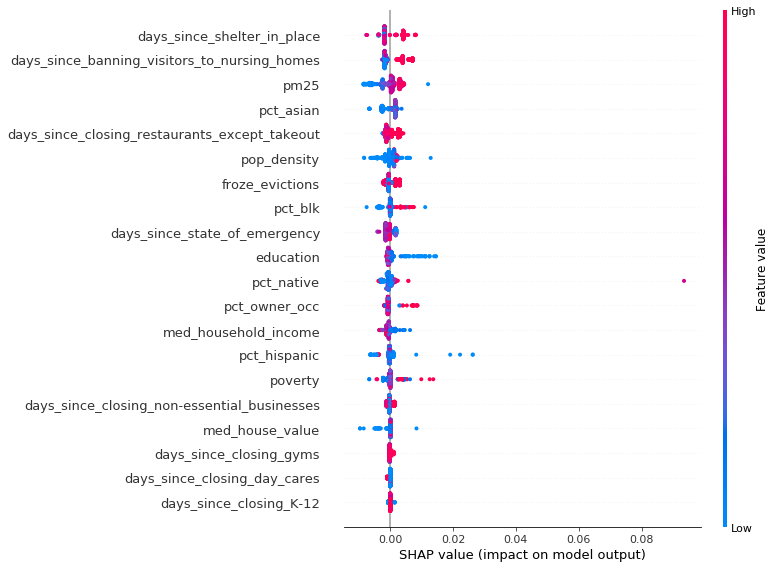

In [30]:
shap.summary_plot(shap_values, X_test)

#### Race and Pollution

Additionally, we find that the mortality effects of this deadly interaction between particulate matter pollution and Covid-19 are acutely felt in regions which are high proportion black. This tragic finding begs correctional measures.

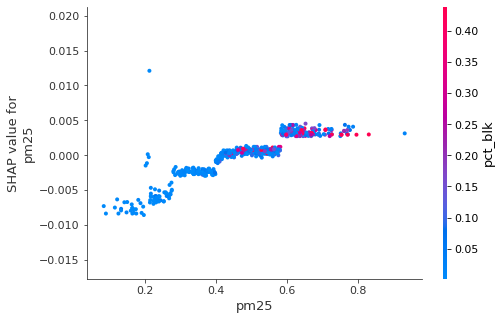

In [38]:
# we can turn off interaction coloring
shap.dependence_plot("pm25", shap_values, X_test, interaction_index = "pct_blk")